<a href="https://colab.research.google.com/github/hany69x/YAZAKI/blob/main/Scikit_Learn_%2B_SEABORN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Index(['Row Labels', '202312', '202313', '202314', '202315', '202317',
       '202319', '202320', '202321', '202322', '202318', '202316', '202323',
       '202324', '202338', '202339', '202340', '202344', '202346', '202350',
       '202348', '202347', '202345', '202343', '202342', '202341', '202325',
       '202326', '202327', '202328', '202329', '202330', '202331', '202332',
       '202333', '202334', '202335', '202336', '202337', '202349', '202351',
       '202352', '202401', '202402', '202403', '202404', '202405', '202407',
       '202406', '202408', '202409', '202410', '202411'],
      dtype='object')
  Row Labels week_year    value  year  week         ds  day_of_week  \
3     Line 3    202312  20188.0  2023    12 2023-03-26            6   
4     Line 4    202312  12186.0  2023    12 2023-03-26            6   
5     Line 5    202312   7470.0  2023    12 2023-03-26            6   
6     Line 6    202312   6203.0  2023    12 2023-03-26            6   
7     Line 7    202312    990.0 

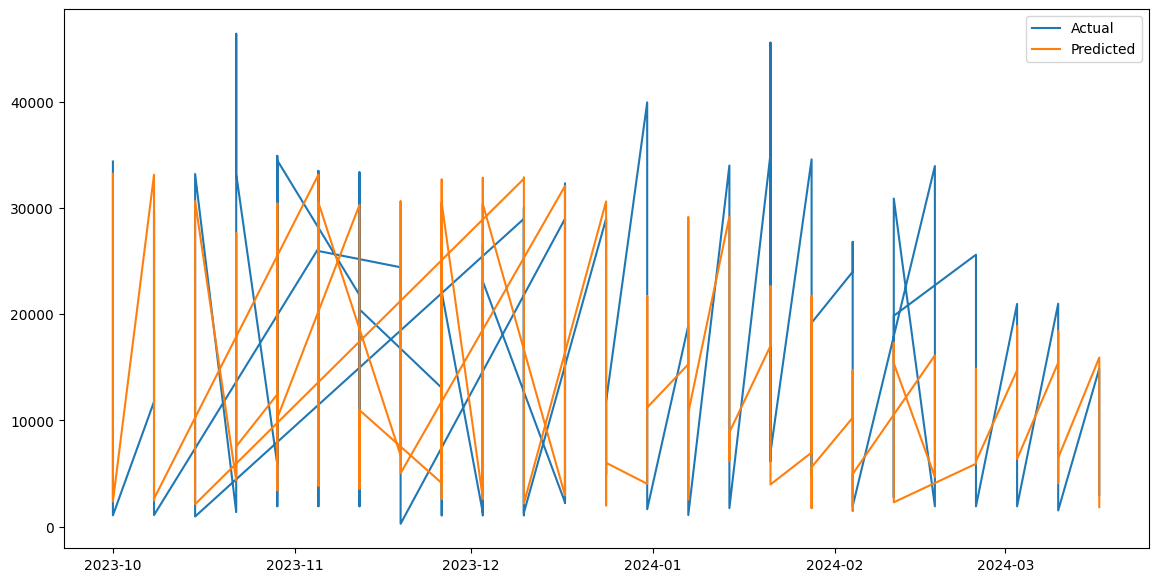

Cross-validated RMSE: 9139.34 ± 1974.88


<ipython-input-6-8220408a67d1>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = y_pred


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt

# Load the dataset
path = "/content/drive/MyDrive/DataSet/YazakiDSET.csv"
df = pd.read_csv(path)

# Remove the 'Sum of ' prefix from the column names
df.columns = [col.replace('Sum of ', '') for col in df.columns]

# Ensure 'Row Labels' is of string type
df['Row Labels'] = df['Row Labels'].astype(str)

# Verify the column names after replacement
print(df.columns)

# Melt the dataframe to long format
df_long = df.melt(id_vars=['Row Labels'], var_name='week_year', value_name='value')

# Extract year and week from the 'week_year' column
df_long['year'] = df_long['week_year'].str[:4].astype(int)
df_long['week'] = df_long['week_year'].str[4:].astype(int)

# Convert year and week to a datetime
df_long['ds'] = pd.to_datetime(df_long['year'].astype(str) + df_long['week'].astype(str) + '0', format='%Y%W%w')

# Filter out non-numeric rows (like 'grand total') if necessary
df_long = df_long[pd.to_numeric(df_long['value'], errors='coerce').notnull()]

# Optionally, filter out rows that are not relevant (e.g., 'grand total')
df_long = df_long[~df_long['Row Labels'].str.contains('grand total', case=False, na=False)]

# Handle missing values (example: forward fill)
df_long['value'] = df_long['value'].fillna(method='ffill')

# Feature engineering for time series
df_long['day_of_week'] = df_long['ds'].dt.dayofweek
df_long['day_of_month'] = df_long['ds'].dt.day
df_long['day_of_year'] = df_long['ds'].dt.dayofyear
df_long['week_of_year'] = df_long['ds'].dt.isocalendar().week
df_long['month'] = df_long['ds'].dt.month
df_long['quarter'] = df_long['ds'].dt.quarter
df_long['year'] = df_long['ds'].dt.year

# Lag features (e.g., previous week's value)
df_long['lag_1'] = df_long['value'].shift(1)
df_long['lag_2'] = df_long['value'].shift(2)
df_long['lag_3'] = df_long['value'].shift(3)

# Drop rows with NaN values (after creating lag features)
df_long = df_long.dropna()

# Print the dataframe to check the preprocessing
print(df_long.head())

# Print the date range in the dataset
print(f"Date range in dataset: {df_long['ds'].min()} to {df_long['ds'].max()}")

# Prepare features (X) and target (y)
X = df_long[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y = df_long['value']

# Print the shape of the feature matrix and target vector
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Choose an appropriate split date within the dataset date range
split_date = '2023-10-01'  # Adjusted split date within the dataset range

# Verify the split date
if not (df_long['ds'].min() <= pd.to_datetime(split_date) <= df_long['ds'].max()):
    raise ValueError(f"Split date {split_date} is outside the range of the dataset dates.")

# Split the data into training and testing sets
train = df_long[df_long['ds'] < split_date]
test = df_long[df_long['ds'] >= split_date]

X_train = train[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_train = train['value']
X_test = test[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_test = test['value']

# Print the shapes of the training and testing sets to verify they are not empty
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Check if the training set is empty
if X_train.shape[0] == 0 or y_train.shape[0] == 0:
    raise ValueError("Training set is empty. Check the split date and ensure there is data before this date.")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_test, label='Actual')
plt.plot(test['ds'], y_pred, label='Predicted')
plt.legend()
plt.show()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}')

# Save the forecast
test['predicted'] = y_pred
test[['ds', 'value', 'predicted']].to_csv('forecast.csv', index=False)

# Save cross-validation metrics
cv_metrics = pd.DataFrame({'rmse': cv_rmse})
cv_metrics.to_csv('performance_metrics.csv', index=False)


Index(['Row Labels', '202312', '202313', '202314', '202315', '202317',
       '202319', '202320', '202321', '202322', '202318', '202316', '202323',
       '202324', '202338', '202339', '202340', '202344', '202346', '202350',
       '202348', '202347', '202345', '202343', '202342', '202341', '202325',
       '202326', '202327', '202328', '202329', '202330', '202331', '202332',
       '202333', '202334', '202335', '202336', '202337', '202349', '202351',
       '202352', '202401', '202402', '202403', '202404', '202405', '202407',
       '202406', '202408', '202409', '202410', '202411'],
      dtype='object')
  Row Labels week_year    value  year  week         ds  day_of_week  \
3     Line 3    202312  20188.0  2023    12 2023-03-26            6   
4     Line 4    202312  12186.0  2023    12 2023-03-26            6   
5     Line 5    202312   7470.0  2023    12 2023-03-26            6   
6     Line 6    202312   6203.0  2023    12 2023-03-26            6   
7     Line 7    202312    990.0 

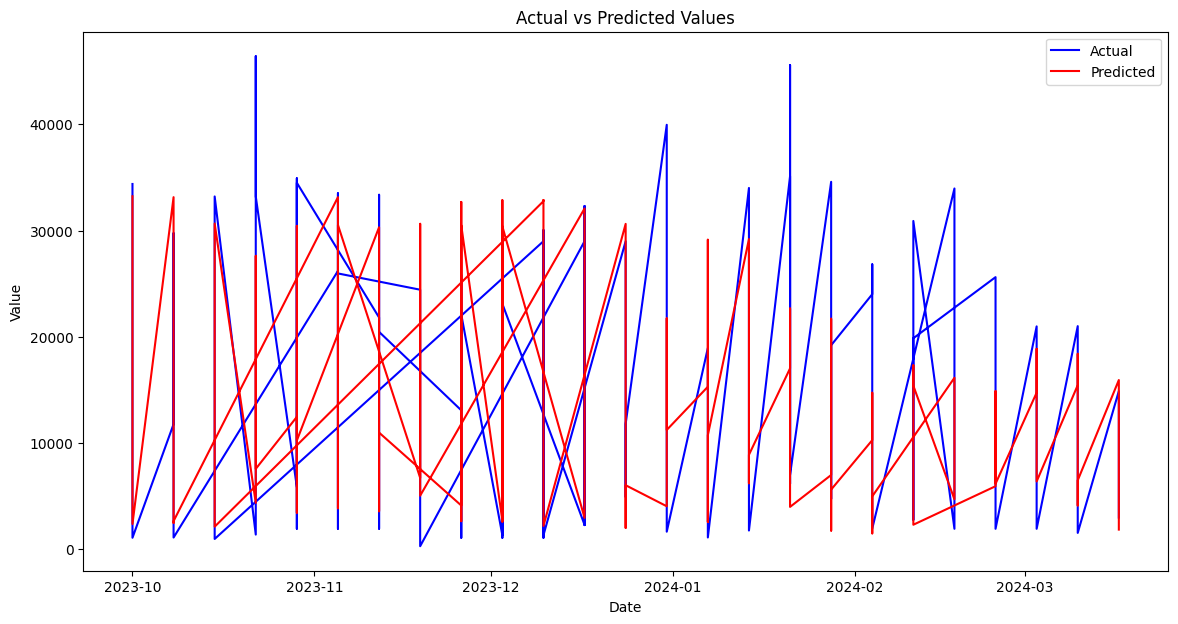

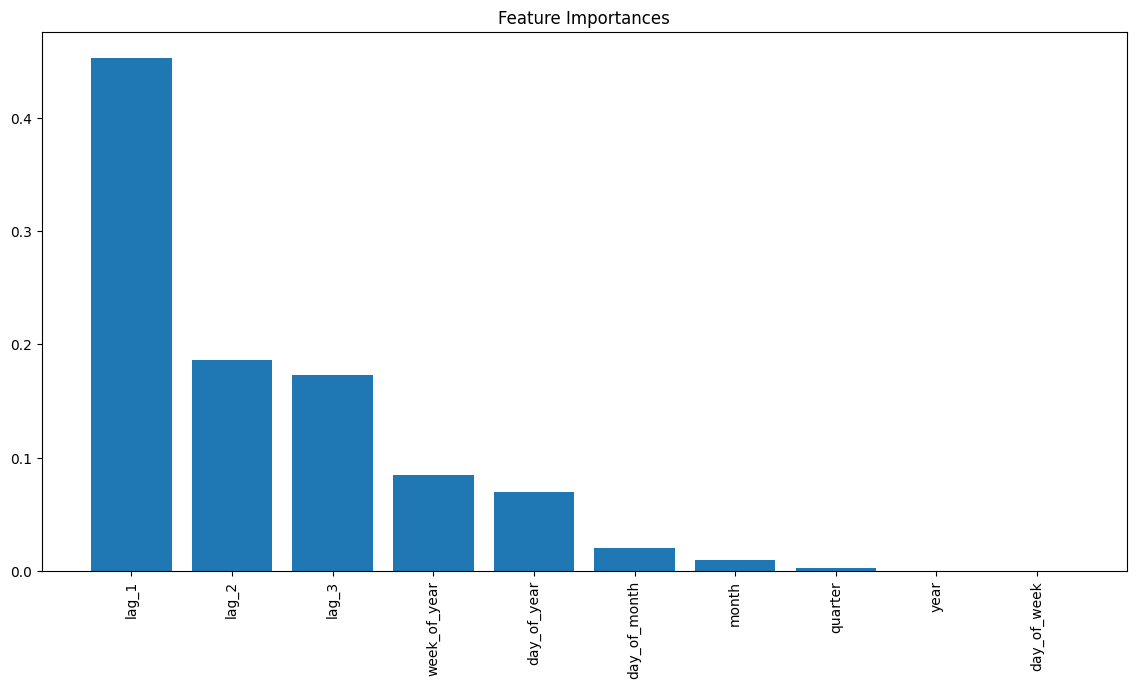

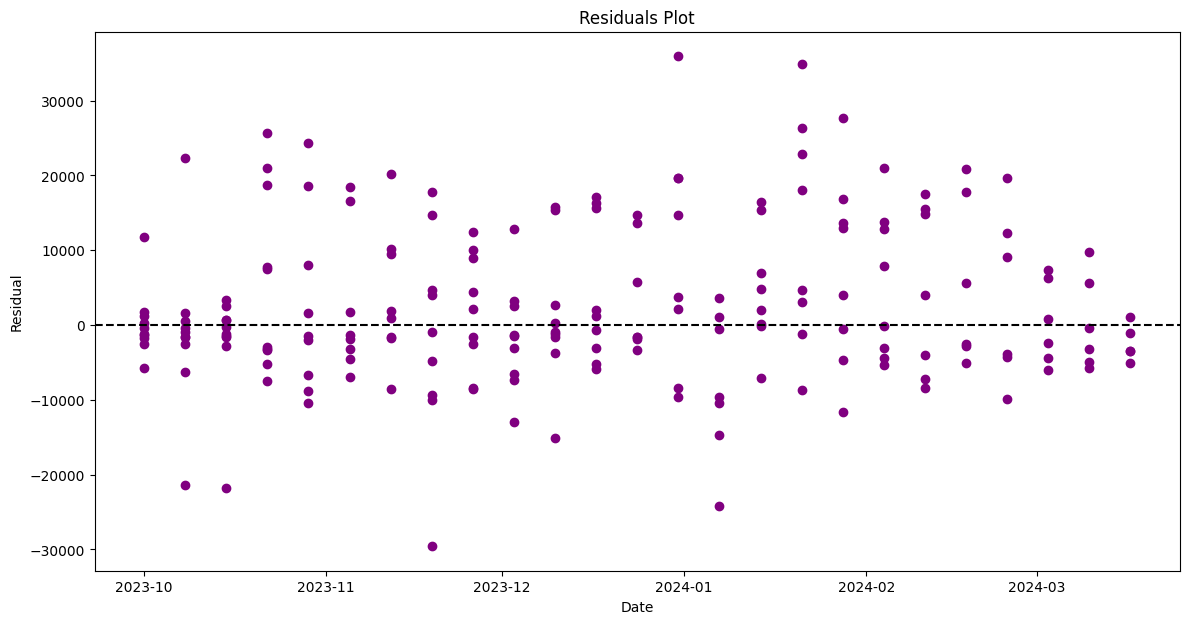

Cross-validated RMSE: 9139.34 ± 1974.88


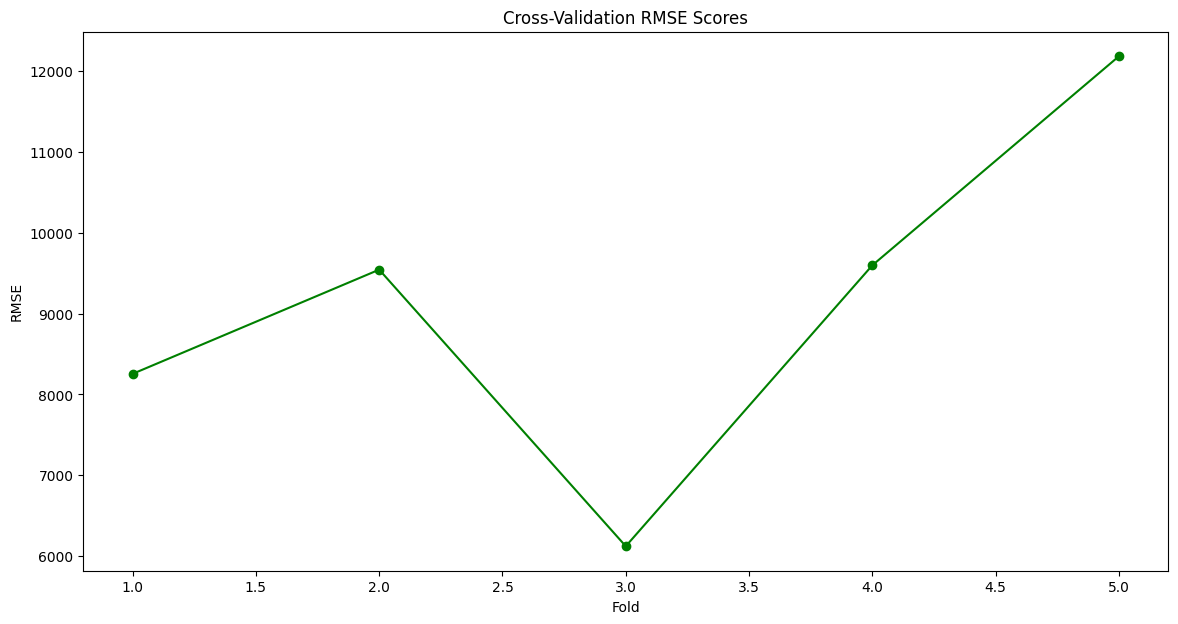

<ipython-input-7-616d19b2d6b3>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = y_pred


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
path = "/content/drive/MyDrive/DataSet/YazakiDSET.csv"
df = pd.read_csv(path)

# Remove the 'Sum of ' prefix from the column names
df.columns = [col.replace('Sum of ', '') for col in df.columns]

# Ensure 'Row Labels' is of string type
df['Row Labels'] = df['Row Labels'].astype(str)

# Verify the column names after replacement
print(df.columns)

# Melt the dataframe to long format
df_long = df.melt(id_vars=['Row Labels'], var_name='week_year', value_name='value')

# Extract year and week from the 'week_year' column
df_long['year'] = df_long['week_year'].str[:4].astype(int)
df_long['week'] = df_long['week_year'].str[4:].astype(int)

# Convert year and week to a datetime
df_long['ds'] = pd.to_datetime(df_long['year'].astype(str) + df_long['week'].astype(str) + '0', format='%Y%W%w')

# Filter out non-numeric rows (like 'grand total') if necessary
df_long = df_long[pd.to_numeric(df_long['value'], errors='coerce').notnull()]

# Optionally, filter out rows that are not relevant (e.g., 'grand total')
df_long = df_long[~df_long['Row Labels'].str.contains('grand total', case=False, na=False)]

# Handle missing values (example: forward fill)
df_long['value'] = df_long['value'].fillna(method='ffill')

# Feature engineering for time series
df_long['day_of_week'] = df_long['ds'].dt.dayofweek
df_long['day_of_month'] = df_long['ds'].dt.day
df_long['day_of_year'] = df_long['ds'].dt.dayofyear
df_long['week_of_year'] = df_long['ds'].dt.isocalendar().week
df_long['month'] = df_long['ds'].dt.month
df_long['quarter'] = df_long['ds'].dt.quarter
df_long['year'] = df_long['ds'].dt.year

# Lag features (e.g., previous week's value)
df_long['lag_1'] = df_long['value'].shift(1)
df_long['lag_2'] = df_long['value'].shift(2)
df_long['lag_3'] = df_long['value'].shift(3)

# Drop rows with NaN values (after creating lag features)
df_long = df_long.dropna()

# Print the dataframe to check the preprocessing
print(df_long.head())

# Print the date range in the dataset
print(f"Date range in dataset: {df_long['ds'].min()} to {df_long['ds'].max()}")

# Prepare features (X) and target (y)
X = df_long[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y = df_long['value']

# Print the shape of the feature matrix and target vector
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Choose an appropriate split date within the dataset date range
split_date = '2023-10-01'  # Adjusted split date within the dataset range

# Verify the split date
if not (df_long['ds'].min() <= pd.to_datetime(split_date) <= df_long['ds'].max()):
    raise ValueError(f"Split date {split_date} is outside the range of the dataset dates.")

# Split the data into training and testing sets
train = df_long[df_long['ds'] < split_date]
test = df_long[df_long['ds'] >= split_date]

X_train = train[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_train = train['value']
X_test = test[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_test = test['value']

# Print the shapes of the training and testing sets to verify they are not empty
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Check if the training set is empty
if X_train.shape[0] == 0 or y_train.shape[0] == 0:
    raise ValueError("Training set is empty. Check the split date and ensure there is data before this date.")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_test, label='Actual', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
plt.scatter(test['ds'], residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.show()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}')

# Plot cross-validation RMSE scores
plt.figure(figsize=(14, 7))
plt.plot(range(1, len(cv_rmse) + 1), cv_rmse, marker='o', linestyle='-', color='green')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE Scores')
plt.show()

# Save the forecast
test['predicted'] = y_pred
test[['ds', 'value', 'predicted']].to_csv('forecast.csv', index=False)

# Save cross-validation metrics
cv_metrics = pd.DataFrame({'rmse': cv_rmse})
cv_metrics.to_csv('performance_metrics.csv', index=False)


Index(['Row Labels', '202312', '202313', '202314', '202315', '202317',
       '202319', '202320', '202321', '202322', '202318', '202316', '202323',
       '202324', '202338', '202339', '202340', '202344', '202346', '202350',
       '202348', '202347', '202345', '202343', '202342', '202341', '202325',
       '202326', '202327', '202328', '202329', '202330', '202331', '202332',
       '202333', '202334', '202335', '202336', '202337', '202349', '202351',
       '202352', '202401', '202402', '202403', '202404', '202405', '202407',
       '202406', '202408', '202409', '202410', '202411'],
      dtype='object')
  Row Labels week_year    value  year  week         ds  day_of_week  \
3     Line 3    202312  20188.0  2023    12 2023-03-26            6   
4     Line 4    202312  12186.0  2023    12 2023-03-26            6   
5     Line 5    202312   7470.0  2023    12 2023-03-26            6   
6     Line 6    202312   6203.0  2023    12 2023-03-26            6   
7     Line 7    202312    990.0 

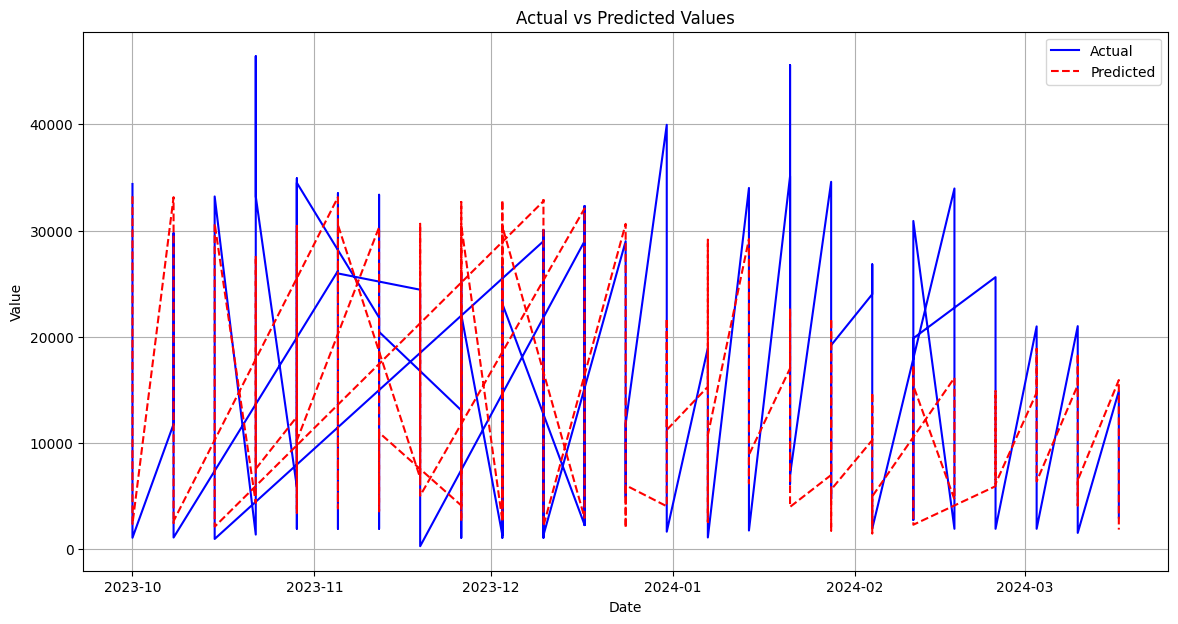

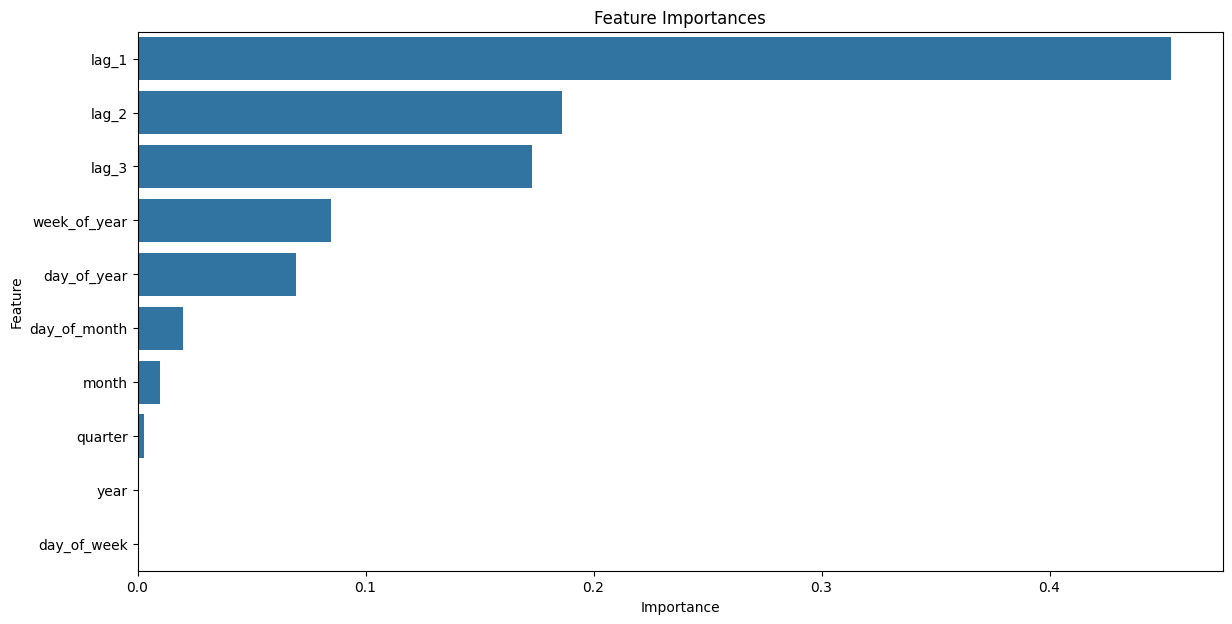

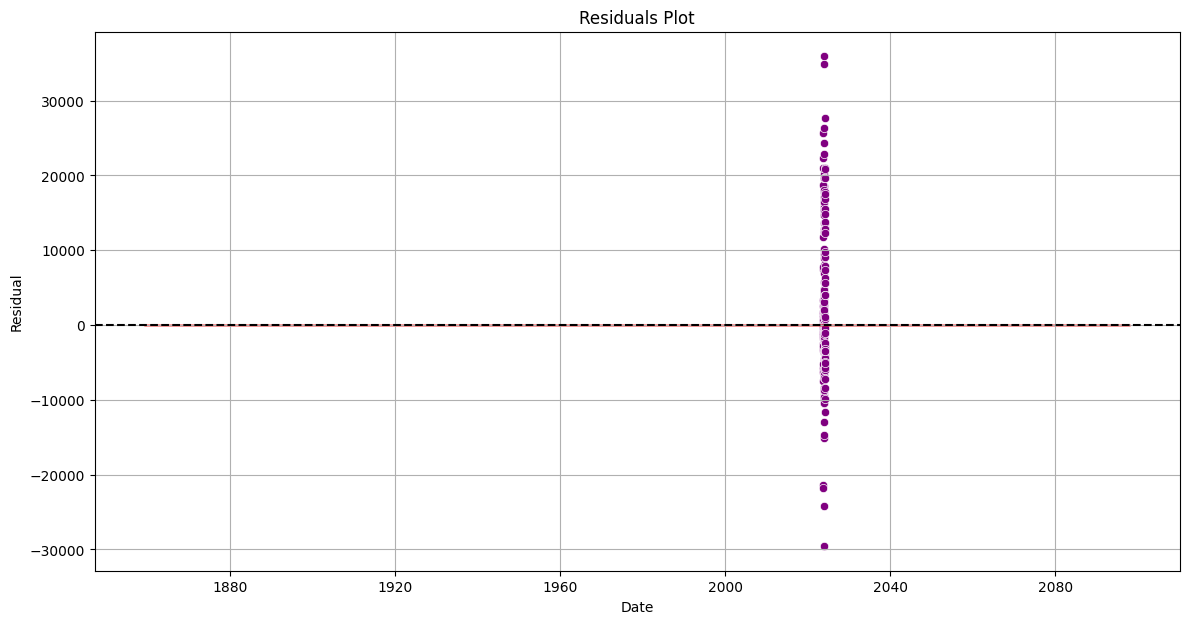

Cross-validated RMSE: 9139.34 ± 1974.88


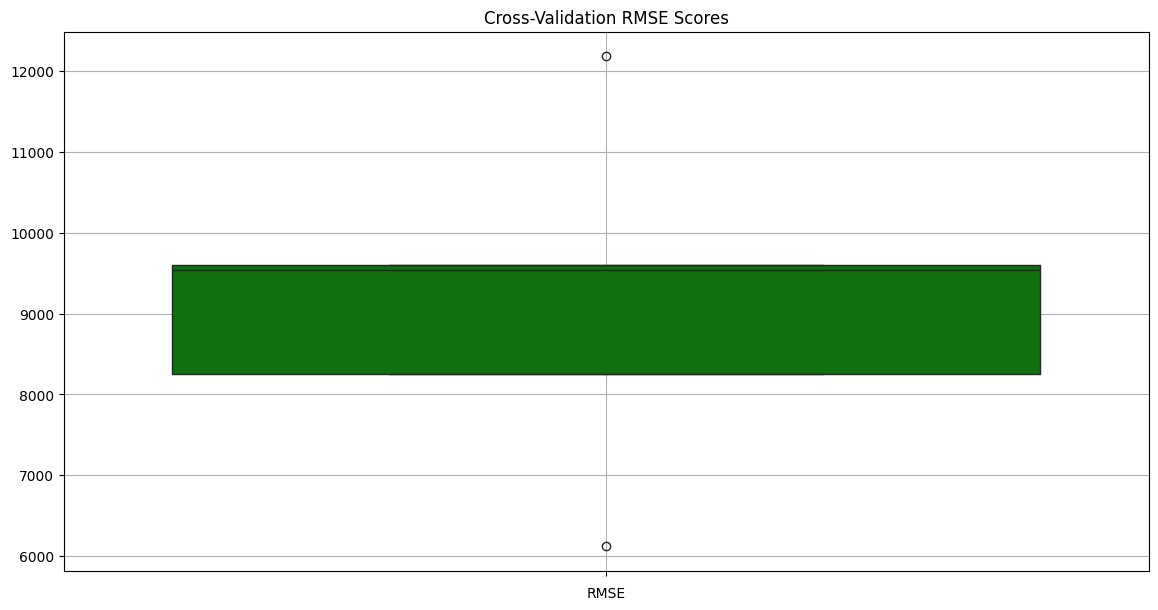

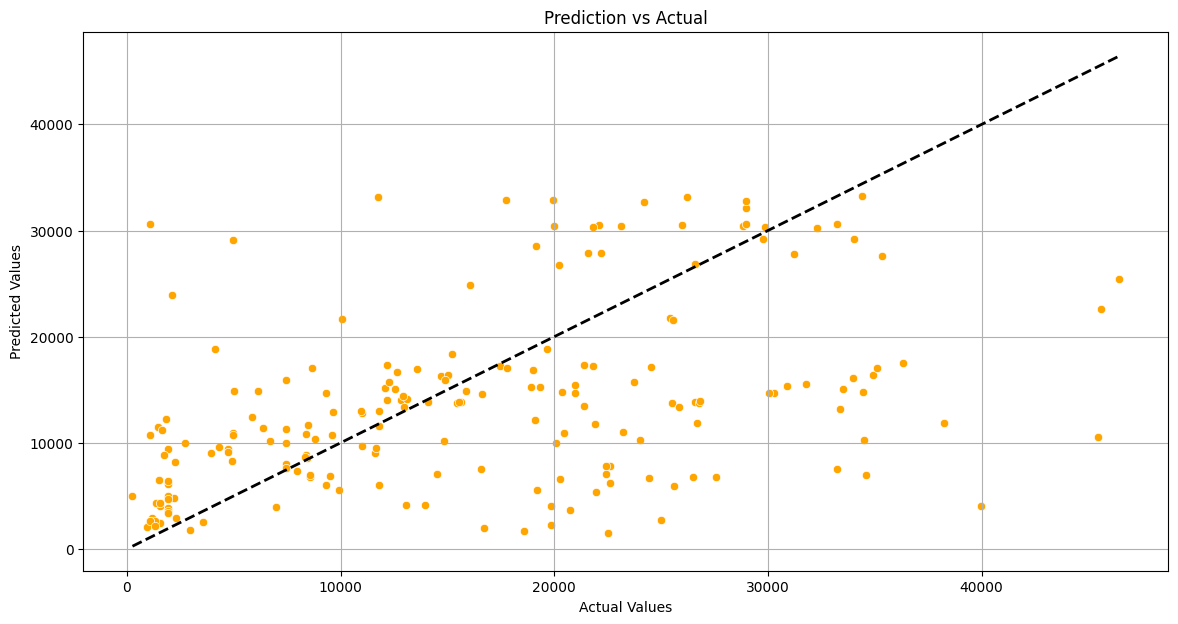

<ipython-input-9-da588ed2253f>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = y_pred


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
path = "/content/drive/MyDrive/DataSet/YazakiDSET.csv"
df = pd.read_csv(path)

# Remove the 'Sum of ' prefix from the column names
df.columns = [col.replace('Sum of ', '') for col in df.columns]

# Ensure 'Row Labels' is of string type
df['Row Labels'] = df['Row Labels'].astype(str)

# Verify the column names after replacement
print(df.columns)

# Melt the dataframe to long format
df_long = df.melt(id_vars=['Row Labels'], var_name='week_year', value_name='value')

# Extract year and week from the 'week_year' column
df_long['year'] = df_long['week_year'].str[:4].astype(int)
df_long['week'] = df_long['week_year'].str[4:].astype(int)

# Convert year and week to a datetime
df_long['ds'] = pd.to_datetime(df_long['year'].astype(str) + df_long['week'].astype(str) + '0', format='%Y%W%w')

# Filter out non-numeric rows (like 'grand total') if necessary
df_long = df_long[pd.to_numeric(df_long['value'], errors='coerce').notnull()]

# Optionally, filter out rows that are not relevant (e.g., 'grand total')
df_long = df_long[~df_long['Row Labels'].str.contains('grand total', case=False, na=False)]

# Handle missing values (example: forward fill)
df_long['value'] = df_long['value'].fillna(method='ffill')

# Feature engineering for time series
df_long['day_of_week'] = df_long['ds'].dt.dayofweek
df_long['day_of_month'] = df_long['ds'].dt.day
df_long['day_of_year'] = df_long['ds'].dt.dayofyear
df_long['week_of_year'] = df_long['ds'].dt.isocalendar().week
df_long['month'] = df_long['ds'].dt.month
df_long['quarter'] = df_long['ds'].dt.quarter
df_long['year'] = df_long['ds'].dt.year

# Lag features (e.g., previous week's value)
df_long['lag_1'] = df_long['value'].shift(1)
df_long['lag_2'] = df_long['value'].shift(2)
df_long['lag_3'] = df_long['value'].shift(3)

# Drop rows with NaN values (after creating lag features)
df_long = df_long.dropna()

# Print the dataframe to check the preprocessing
print(df_long.head())

# Print the date range in the dataset
print(f"Date range in dataset: {df_long['ds'].min()} to {df_long['ds'].max()}")

# Prepare features (X) and target (y)
X = df_long[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y = df_long['value']

# Print the shape of the feature matrix and target vector
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Choose an appropriate split date within the dataset date range
split_date = '2023-10-01'  # Adjusted split date within the dataset range

# Verify the split date
if not (df_long['ds'].min() <= pd.to_datetime(split_date) <= df_long['ds'].max()):
    raise ValueError(f"Split date {split_date} is outside the range of the dataset dates.")

# Split the data into training and testing sets
train = df_long[df_long['ds'] < split_date]
test = df_long[df_long['ds'] >= split_date]

X_train = train[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_train = train['value']
X_test = test[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_test = test['value']

# Print the shapes of the training and testing sets to verify they are not empty
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Check if the training set is empty
if X_train.shape[0] == 0 or y_train.shape[0] == 0:
    raise ValueError("Training set is empty. Check the split date and ensure there is data before this date.")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_test, label='Actual', color='blue', linestyle='-')
plt.plot(test['ds'], y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=[features[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot residuals with density
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
sns.scatterplot(x=test['ds'], y=residuals, color='purple')
sns.kdeplot(residuals, color='red', fill=True, alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}')

# Plot cross-validation RMSE scores with boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(cv_rmse, color='green')
plt.xlabel('RMSE')
plt.title('Cross-Validation RMSE Scores')
plt.grid(True)
plt.show()

# Plot Prediction vs Actual
plt.figure(figsize=(14, 7))
sns.scatterplot(x=y_test, y=y_pred, color='orange')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

# Save the forecast
test['predicted'] = y_pred
test[['ds', 'value', 'predicted']].to_csv('forecast.csv', index=False)

# Save cross-validation metrics
cv_metrics = pd.DataFrame({'rmse': cv_rmse})
cv_metrics.to_csv('performance_metrics.csv', index=False)


Index(['Row Labels', '202312', '202313', '202314', '202315', '202317',
       '202319', '202320', '202321', '202322', '202318', '202316', '202323',
       '202324', '202338', '202339', '202340', '202344', '202346', '202350',
       '202348', '202347', '202345', '202343', '202342', '202341', '202325',
       '202326', '202327', '202328', '202329', '202330', '202331', '202332',
       '202333', '202334', '202335', '202336', '202337', '202349', '202351',
       '202352', '202401', '202402', '202403', '202404', '202405', '202407',
       '202406', '202408', '202409', '202410', '202411'],
      dtype='object')
  Row Labels week_year    value  year  week         ds  day_of_week  \
3     Line 3    202312  20188.0  2023    12 2023-03-26            6   
4     Line 4    202312  12186.0  2023    12 2023-03-26            6   
5     Line 5    202312   7470.0  2023    12 2023-03-26            6   
6     Line 6    202312   6203.0  2023    12 2023-03-26            6   
7     Line 7    202312    990.0 

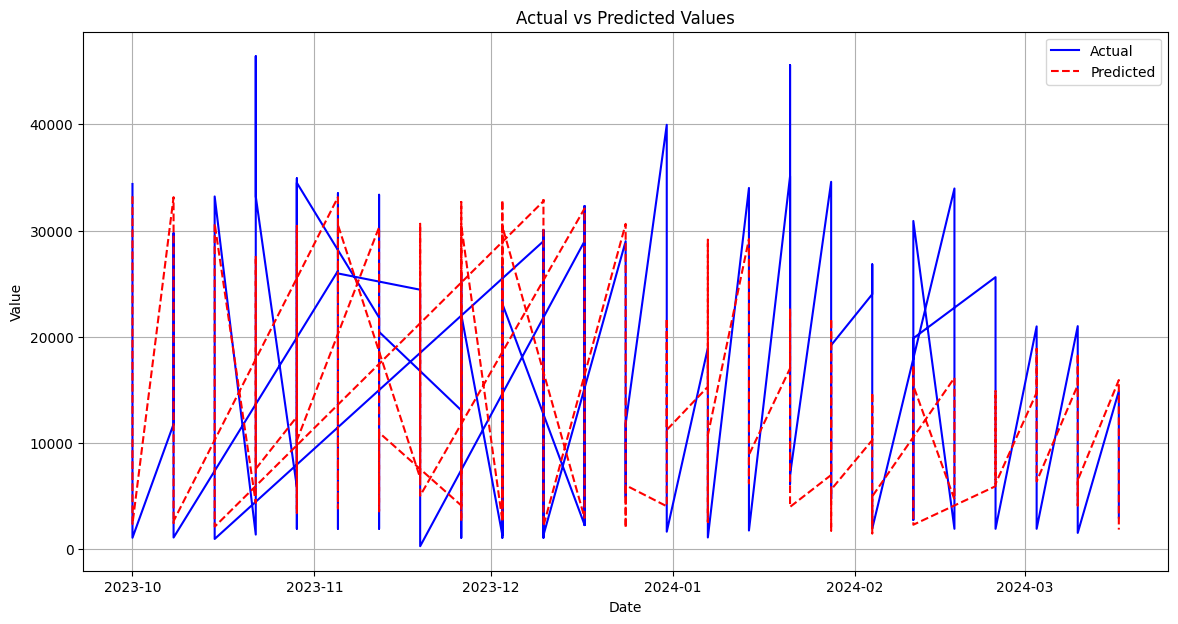

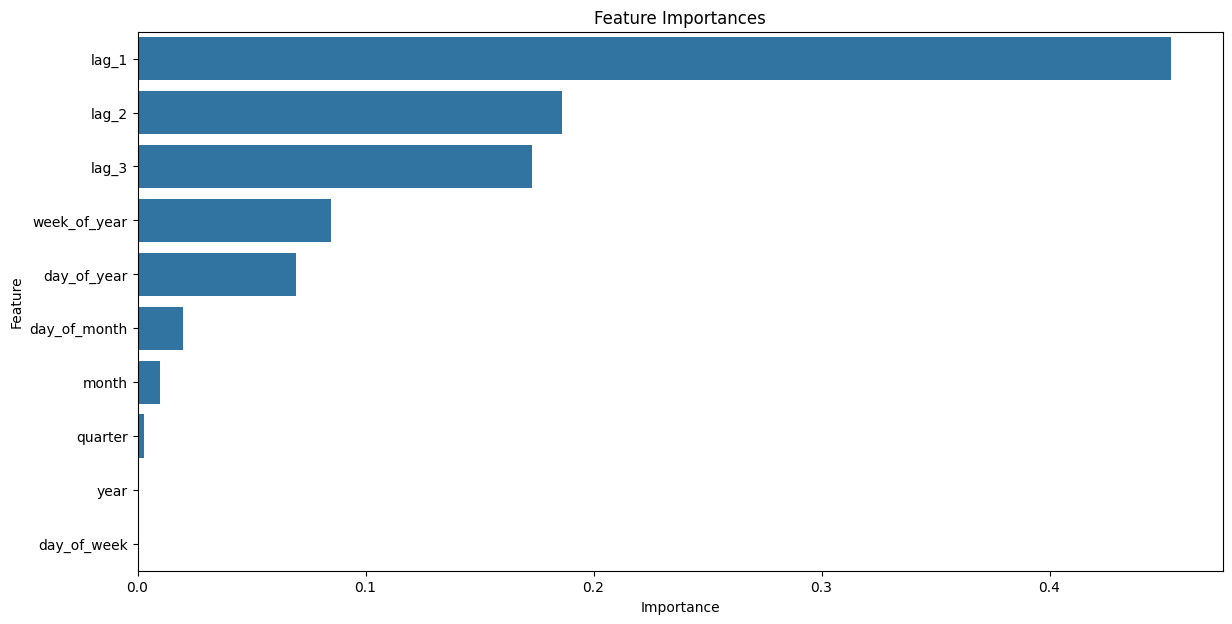

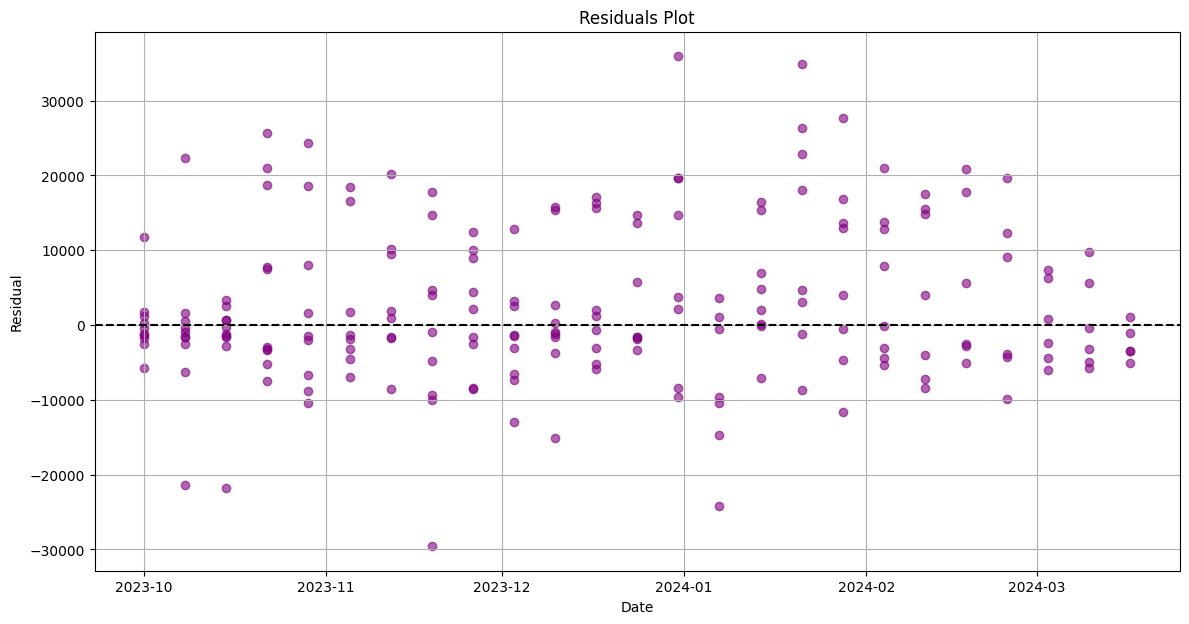

Cross-validated RMSE: 9139.34 ± 1974.88


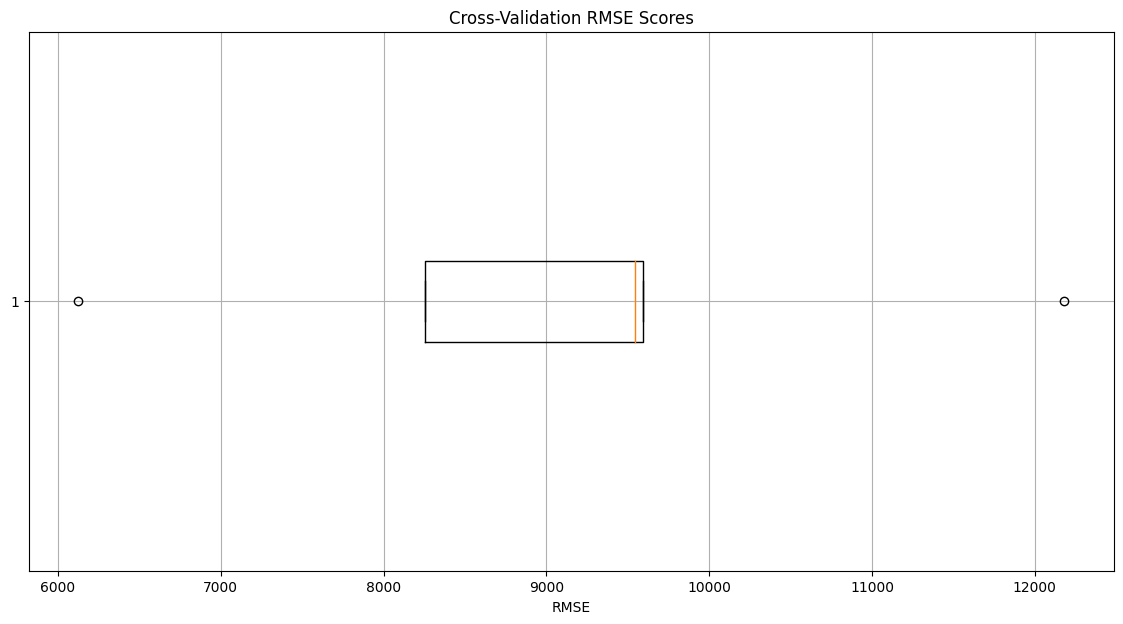

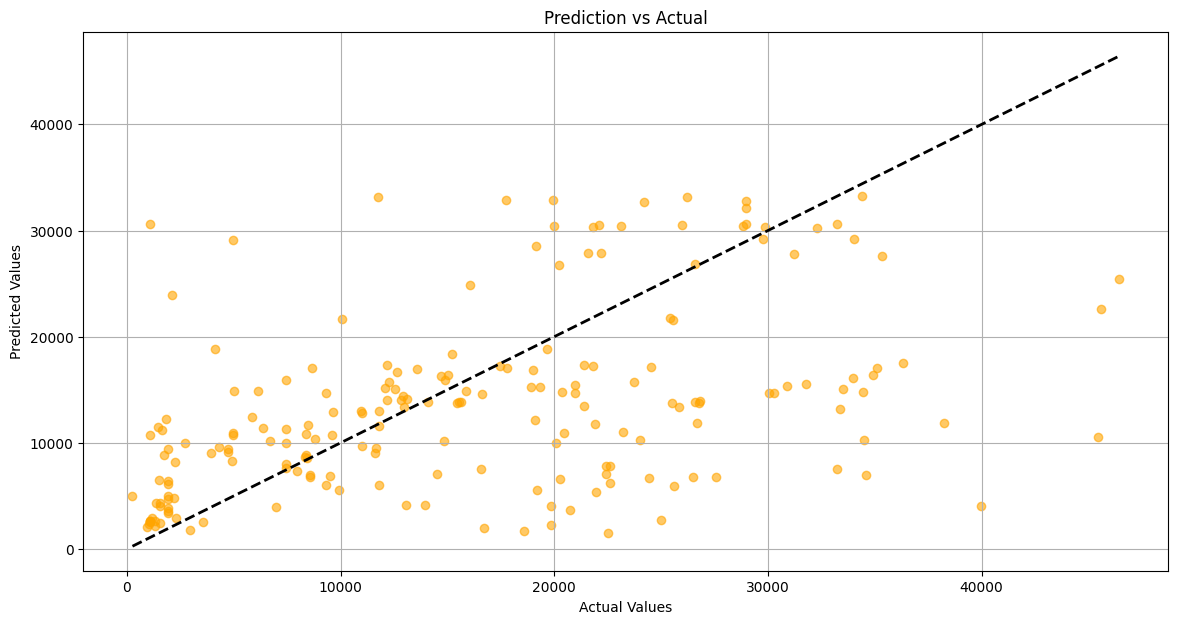

<ipython-input-10-0c075bd003ed>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = y_pred


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
path = "/content/drive/MyDrive/DataSet/YazakiDSET.csv"
df = pd.read_csv(path)

# Remove the 'Sum of ' prefix from the column names
df.columns = [col.replace('Sum of ', '') for col in df.columns]

# Ensure 'Row Labels' is of string type
df['Row Labels'] = df['Row Labels'].astype(str)

# Verify the column names after replacement
print(df.columns)

# Melt the dataframe to long format
df_long = df.melt(id_vars=['Row Labels'], var_name='week_year', value_name='value')

# Extract year and week from the 'week_year' column
df_long['year'] = df_long['week_year'].str[:4].astype(int)
df_long['week'] = df_long['week_year'].str[4:].astype(int)

# Convert year and week to a datetime
df_long['ds'] = pd.to_datetime(df_long['year'].astype(str) + df_long['week'].astype(str) + '0', format='%Y%W%w')

# Filter out non-numeric rows (like 'grand total') if necessary
df_long = df_long[pd.to_numeric(df_long['value'], errors='coerce').notnull()]

# Optionally, filter out rows that are not relevant (e.g., 'grand total')
df_long = df_long[~df_long['Row Labels'].str.contains('grand total', case=False, na=False)]

# Handle missing values (example: forward fill)
df_long['value'] = df_long['value'].fillna(method='ffill')

# Feature engineering for time series
df_long['day_of_week'] = df_long['ds'].dt.dayofweek
df_long['day_of_month'] = df_long['ds'].dt.day
df_long['day_of_year'] = df_long['ds'].dt.dayofyear
df_long['week_of_year'] = df_long['ds'].dt.isocalendar().week
df_long['month'] = df_long['ds'].dt.month
df_long['quarter'] = df_long['ds'].dt.quarter
df_long['year'] = df_long['ds'].dt.year

# Lag features (e.g., previous week's value)
df_long['lag_1'] = df_long['value'].shift(1)
df_long['lag_2'] = df_long['value'].shift(2)
df_long['lag_3'] = df_long['value'].shift(3)

# Drop rows with NaN values (after creating lag features)
df_long = df_long.dropna()

# Print the dataframe to check the preprocessing
print(df_long.head())

# Print the date range in the dataset
print(f"Date range in dataset: {df_long['ds'].min()} to {df_long['ds'].max()}")

# Prepare features (X) and target (y)
X = df_long[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y = df_long['value']

# Print the shape of the feature matrix and target vector
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Choose an appropriate split date within the dataset date range
split_date = '2023-10-01'  # Adjusted split date within the dataset range

# Verify the split date
if not (df_long['ds'].min() <= pd.to_datetime(split_date) <= df_long['ds'].max()):
    raise ValueError(f"Split date {split_date} is outside the range of the dataset dates.")

# Split the data into training and testing sets
train = df_long[df_long['ds'] < split_date]
test = df_long[df_long['ds'] >= split_date]

X_train = train[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_train = train['value']
X_test = test[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_test = test['value']

# Print the shapes of the training and testing sets to verify they are not empty
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Check if the training set is empty
if X_train.shape[0] == 0 or y_train.shape[0] == 0:
    raise ValueError("Training set is empty. Check the split date and ensure there is data before this date.")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_test, label='Actual', color='blue', linestyle='-')
plt.plot(test['ds'], y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=[features[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Simplified residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
plt.scatter(test['ds'], residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}')

# Simplified cross-validation RMSE plot
plt.figure(figsize=(14, 7))
plt.boxplot(cv_rmse, vert=False)
plt.xlabel('RMSE')
plt.title('Cross-Validation RMSE Scores')
plt.grid(True)
plt.show()

# Plot Prediction vs Actual
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_pred, color='orange', alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

# Save the forecast
test['predicted'] = y_pred
test[['ds', 'value', 'predicted']].to_csv('forecast.csv', index=False)

# Save cross-validation metrics
cv_metrics = pd.DataFrame({'rmse': cv_rmse})
cv_metrics.to_csv('performance_metrics.csv', index=False)


Index(['Row Labels', '202312', '202313', '202314', '202315', '202317',
       '202319', '202320', '202321', '202322', '202318', '202316', '202323',
       '202324', '202338', '202339', '202340', '202344', '202346', '202350',
       '202348', '202347', '202345', '202343', '202342', '202341', '202325',
       '202326', '202327', '202328', '202329', '202330', '202331', '202332',
       '202333', '202334', '202335', '202336', '202337', '202349', '202351',
       '202352', '202401', '202402', '202403', '202404', '202405', '202407',
       '202406', '202408', '202409', '202410', '202411'],
      dtype='object')
  Row Labels week_year    value  year  week         ds  day_of_week  \
3     Line 3    202312  20188.0  2023    12 2023-03-26            6   
4     Line 4    202312  12186.0  2023    12 2023-03-26            6   
5     Line 5    202312   7470.0  2023    12 2023-03-26            6   
6     Line 6    202312   6203.0  2023    12 2023-03-26            6   
7     Line 7    202312    990.0 

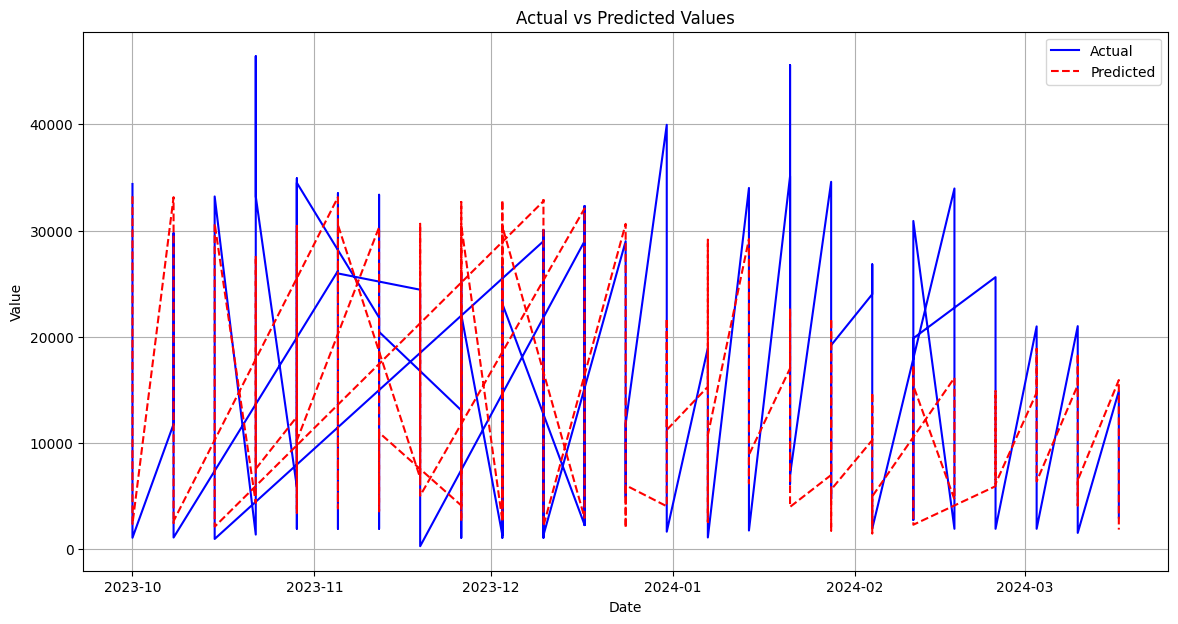

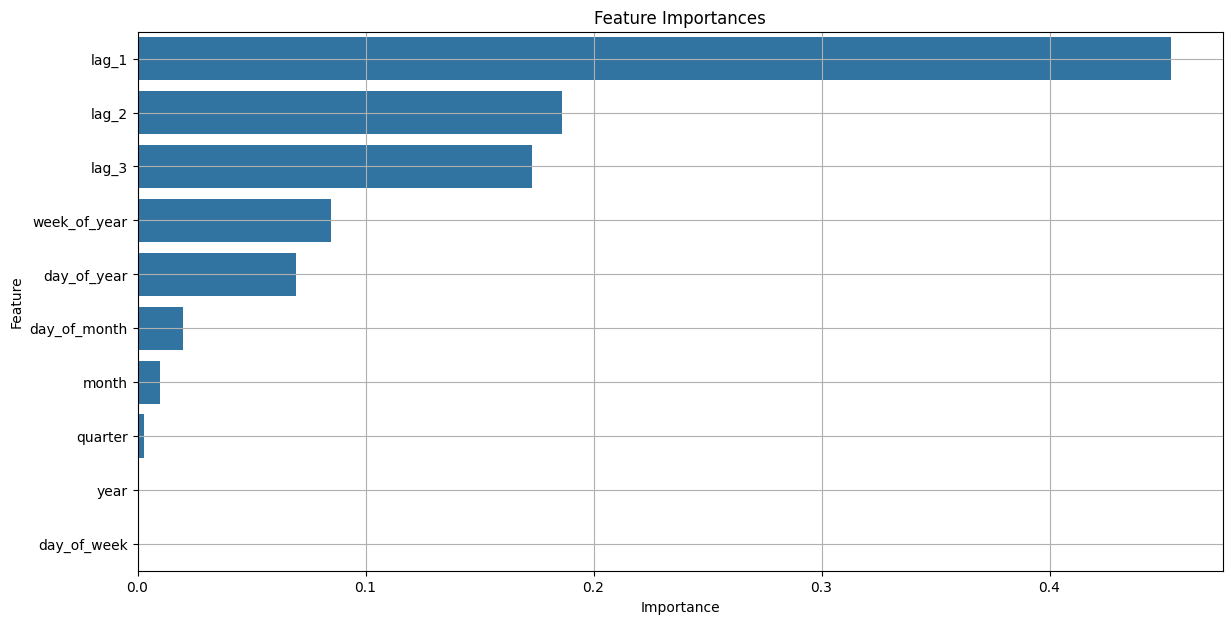

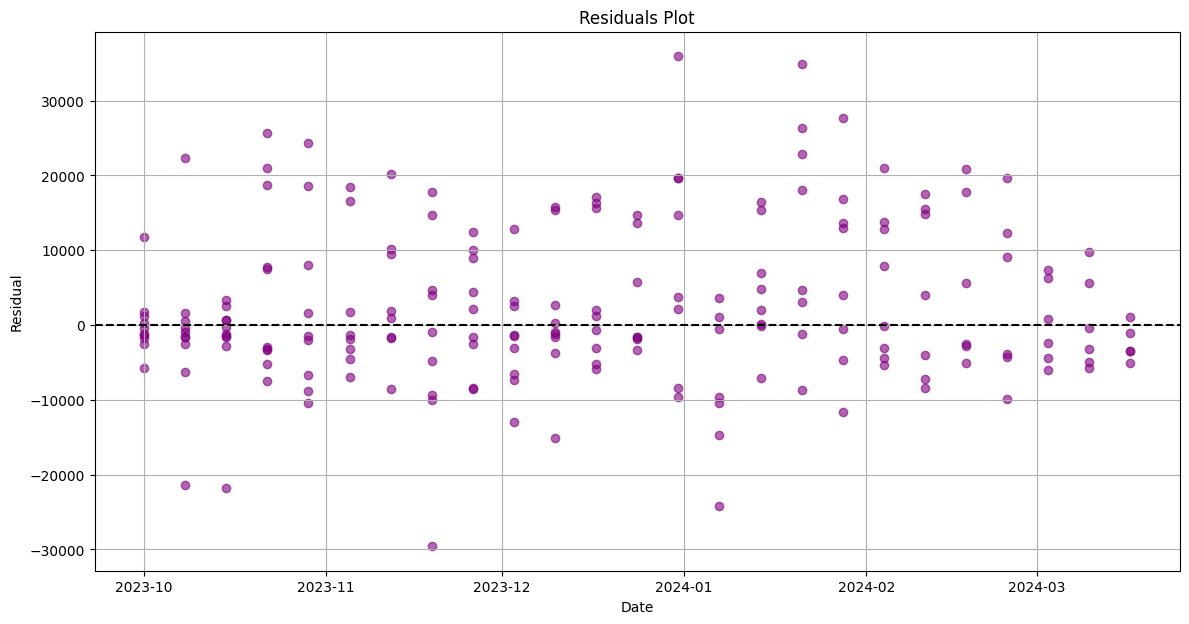

Cross-validated RMSE: 9139.34 ± 1974.88


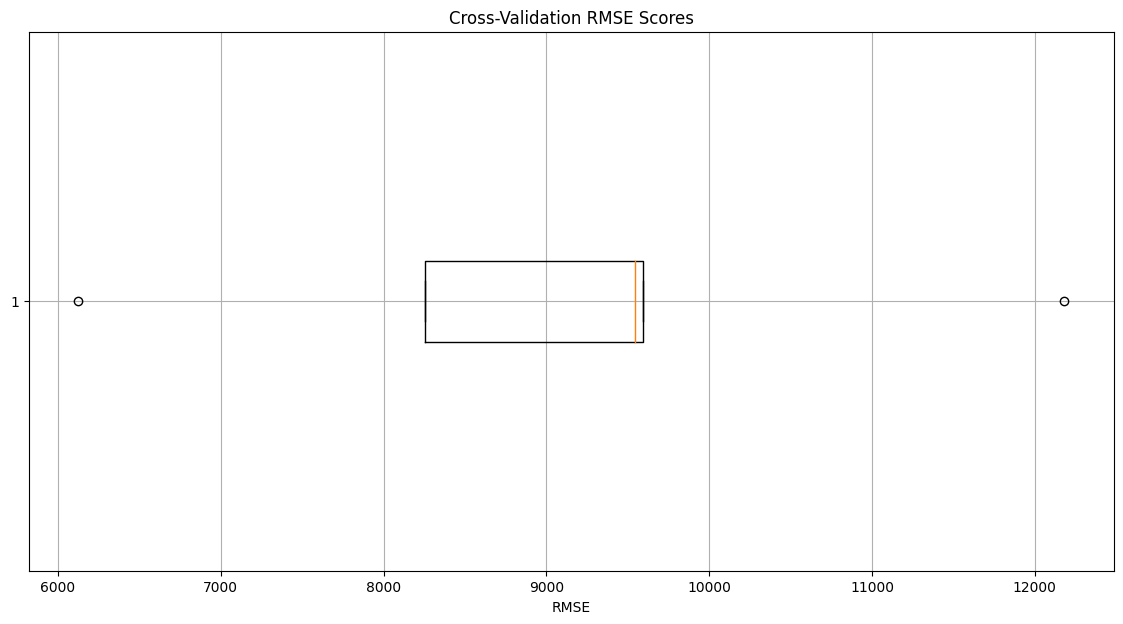

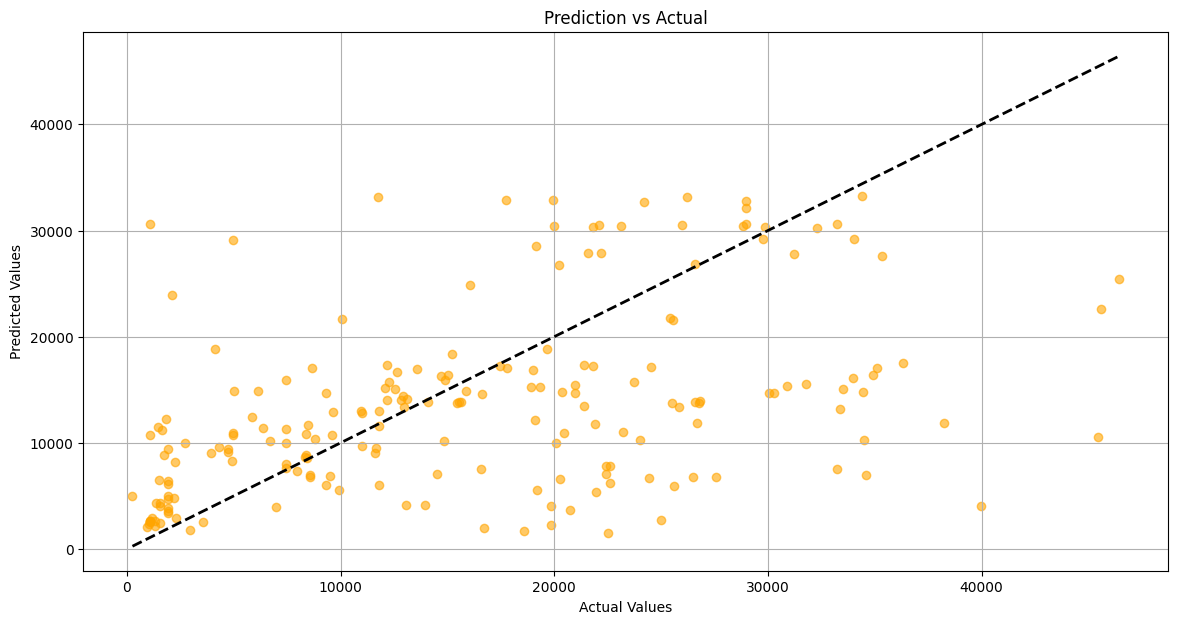

<ipython-input-11-42665d2349c2>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = y_pred


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
path = "/content/drive/MyDrive/DataSet/YazakiDSET.csv"
df = pd.read_csv(path)

# Remove the 'Sum of ' prefix from the column names
df.columns = [col.replace('Sum of ', '') for col in df.columns]

# Ensure 'Row Labels' is of string type
df['Row Labels'] = df['Row Labels'].astype(str)

# Verify the column names after replacement
print(df.columns)

# Melt the dataframe to long format
df_long = df.melt(id_vars=['Row Labels'], var_name='week_year', value_name='value')

# Extract year and week from the 'week_year' column
df_long['year'] = df_long['week_year'].str[:4].astype(int)
df_long['week'] = df_long['week_year'].str[4:].astype(int)

# Convert year and week to a datetime
df_long['ds'] = pd.to_datetime(df_long['year'].astype(str) + df_long['week'].astype(str) + '0', format='%Y%W%w')

# Filter out non-numeric rows (like 'grand total') if necessary
df_long = df_long[pd.to_numeric(df_long['value'], errors='coerce').notnull()]

# Optionally, filter out rows that are not relevant (e.g., 'grand total')
df_long = df_long[~df_long['Row Labels'].str.contains('grand total', case=False, na=False)]

# Handle missing values (example: forward fill)
df_long['value'] = df_long['value'].fillna(method='ffill')

# Feature engineering for time series
df_long['day_of_week'] = df_long['ds'].dt.dayofweek
df_long['day_of_month'] = df_long['ds'].dt.day
df_long['day_of_year'] = df_long['ds'].dt.dayofyear
df_long['week_of_year'] = df_long['ds'].dt.isocalendar().week
df_long['month'] = df_long['ds'].dt.month
df_long['quarter'] = df_long['ds'].dt.quarter
df_long['year'] = df_long['ds'].dt.year

# Lag features (e.g., previous week's value)
df_long['lag_1'] = df_long['value'].shift(1)
df_long['lag_2'] = df_long['value'].shift(2)
df_long['lag_3'] = df_long['value'].shift(3)

# Drop rows with NaN values (after creating lag features)
df_long = df_long.dropna()

# Print the dataframe to check the preprocessing
print(df_long.head())

# Print the date range in the dataset
print(f"Date range in dataset: {df_long['ds'].min()} to {df_long['ds'].max()}")

# Prepare features (X) and target (y)
X = df_long[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y = df_long['value']

# Print the shape of the feature matrix and target vector
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Choose an appropriate split date within the dataset date range
split_date = '2023-10-01'  # Adjusted split date within the dataset range

# Verify the split date
if not (df_long['ds'].min() <= pd.to_datetime(split_date) <= df_long['ds'].max()):
    raise ValueError(f"Split date {split_date} is outside the range of the dataset dates.")

# Split the data into training and testing sets
train = df_long[df_long['ds'] < split_date]
test = df_long[df_long['ds'] >= split_date]

X_train = train[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_train = train['value']
X_test = test[['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3']]
y_test = test['value']

# Print the shapes of the training and testing sets to verify they are not empty
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Check if the training set is empty
if X_train.shape[0] == 0 or y_train.shape[0] == 0:
    raise ValueError("Training set is empty. Check the split date and ensure there is data before this date.")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_test, label='Actual', color='blue', linestyle='-')
plt.plot(test['ds'], y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=[features[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

# Simplified residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
plt.scatter(test['ds'], residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}')

# Simplified cross-validation RMSE plot
plt.figure(figsize=(14, 7))
plt.boxplot(cv_rmse, vert=False)
plt.xlabel('RMSE')
plt.title('Cross-Validation RMSE Scores')
plt.grid(True)
plt.show()

# Plot Prediction vs Actual
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_pred, color='orange', alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

# Save the forecast
test['predicted'] = y_pred
test[['ds', 'value', 'predicted']].to_csv('forecast.csv', index=False)

# Save cross-validation metrics
cv_metrics = pd.DataFrame({'rmse': cv_rmse})
cv_metrics.to_csv('performance_metrics.csv', index=False)
